# Baseline **LSTM** Frame Predictor

A companion to the Transformer notebook — shares the same dataset loading,
section layout, and training loop so you can compare apples‑to‑apples.

<small>*(Sections are numbered & boxed exactly like the Transformer notebook.)*</small>

In [18]:
# ╔════════════════════════════╗
# ║ 0. Environment – GPU check ║
# ╚════════════════════════════╝

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ {len(gpus)} GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("⚠️ No GPU found. Training will be slow.")



⚠️ No GPU found. Training will be slow.


In [20]:
# ╔═════════════════════════════════╗
# ║ 1. Load train/val/test datasets ║
# ╚═════════════════════════════════╝

DATA_PATH = "../processed_data/transformer_dataset/"

full_ds = tf.data.Dataset.load(DATA_PATH)

# Split datasets based on meta_vec[2] (split_id: 0=train, 1=val, 2=test)
def filter_split(split_id):
    return full_ds.filter(lambda meta, x, y: meta[2] == split_id)

train_ds = filter_split(0).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
val_ds   = filter_split(1).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds  = filter_split(2).map(lambda meta, x, y: (x, y)).batch(128).prefetch(tf.data.AUTOTUNE)

print("✅ Datasets loaded and batched.")


✅ Datasets loaded and batched.


In [21]:
# ╔══════════════════════╗
# ║ 2. Build LSTM Model ║
# ╚══════════════════════╝

from tensorflow.keras import layers, models

MAX_SEQ_LEN = 100
NUM_ENTITIES = 23
INPUT_DIM = NUM_ENTITIES * 2   # x and y only (46)

# Model
inputs = tf.keras.Input(shape=(MAX_SEQ_LEN, INPUT_DIM))  # (batch, 100, 46)

x = layers.Masking(mask_value=0.0)(inputs)  # Optional if sequences are padded
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(128, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)

# Predict next frame: 46 outputs (23 players × 2 coordinates)
outputs = layers.Dense(INPUT_DIM)(x)

model = models.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 46)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 100, 46)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 100, 46)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 100)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 256)  │    310,272 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 256)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    197,120 │ dropout[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 46)        │      5,934 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513,326 (1.96 MB)

 Trainable params: 513,326 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ╔══════════════════════╗
# ║ 3. Compile Model    ║
# ╚══════════════════════╝

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)


In [23]:
# ╔════════════════════════════════════════╗
# ║ 4. Set up callbacks (EarlyStopping etc) ║
# ╚════════════════════════════════════════╝

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Save best model automatically
checkpoint_cb = ModelCheckpoint(
    filepath="saved_models/lstm_position_only_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


In [ ]:
# ╔═══════════════════════════════════════════╗
# ║ 5. Train the model (with timing & callbacks) ║
# ╚═══════════════════════════════════════════╝


EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)


Epoch 1/30
   3040/Unknown 2289s 753ms/step - loss: 0.0169 - mae: 0.0935

2025-04-28 08:34:12.732917: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/NFL_env/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00238, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 2621s 862ms/step - loss: 0.0169 - mae: 0.0935 - val_loss: 0.0024 - val_mae: 0.0365
Epoch 2/30
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0042 - mae: 0.0496

2025-04-28 09:41:23.391909: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_loss improved from 0.00238 to 0.00214, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 3789s 1s/step - loss: 0.0042 - mae: 0.0496 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 3/30
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0033 - mae: 0.0438
Epoch 3: val_loss improved from 0.00214 to 0.00204, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 5022s 2s/step - loss: 0.0033 - mae: 0.0438 - val_loss: 0.0020 - val_mae: 0.0339
Epoch 4/30
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.0029 - mae: 0.0407

2025-04-28 11:26:52.233376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 0.00204 to 0.00142, saving model to saved_models/lstm_position_only_best.keras
3040/3040 ━━━━━━━━━━━━━━━━━━━━ 1314s 432ms/step - loss: 0.0029 - mae: 0.0407 - val_loss: 0.0014 - val_mae: 0.0273
Epoch 5/30
2388/3040 ━━━━━━━━━━━━━━━━━━━━ 7:45 713ms/step - loss: 0.0028 - mae: 0.0398

KeyboardInterrupt: 

In [ ]:
# ╔═════════════════════╗
# ║ 6. Save final model ║
# ╚═════════════════════╝

model.save("saved_models/lstm_position_only_final.keras")
print("✅ Final model saved!")


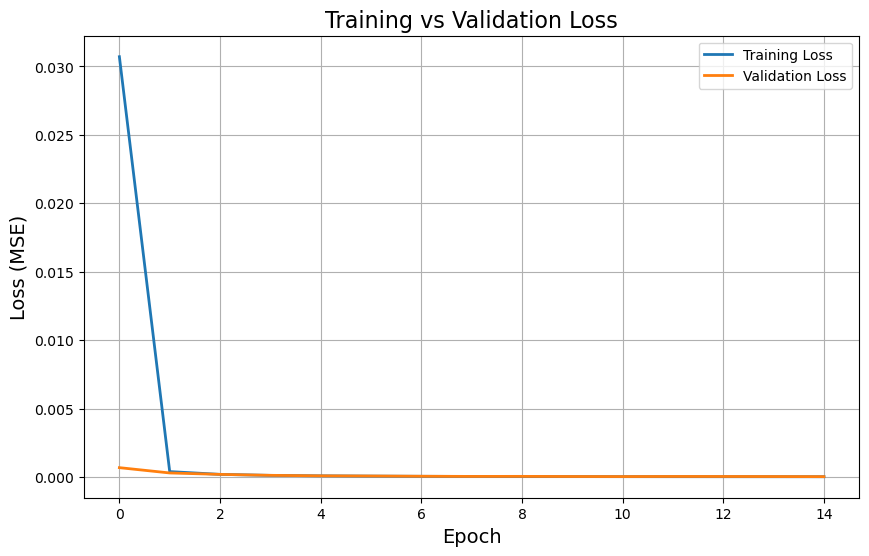

In [26]:
# ╔════════════════════════════════════════╗
# ║ 7. Plot training and validation curves ║
# ╚════════════════════════════════════════╝

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
